# TP Deep Learning

# Eye tracking

<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Percept_eye_tracking.png">

Aujourd'hui sera un mini projet basé sur Eye Tracking ! Un peu de contexte d'abord. 

Vous avez beaucoup d'images avec des noms normés, leurs noms indiquent plusieurs informations :

- **subject ID** :

        xxx

- **image number** :

        xxx

- **gender** :

        0 - male
        1 - famale

- **glasses** :

        0 - no
        1 - yes

- **eye state** :

        0 - close
        1 - open

- **reflections** :

        0 - none
        1 - low
        2 - high

- **lighting conditions/image quality** :

        0 - bad
        1 - good

- **sensor type** :

        01 - RealSense SR300 640x480
        02 - IDS Imaging, 1280x1024
        03 - Aptina Imagin 752x480

- **example** :

        s001_00123_0_0_0_0_0_01.png


Dans les dossier `data/open` et `data/close`, sont présentes des images d'yeux, ouverts ou fermés. Vous aurez deux tâches principales :

- **Classification** : créer un classificateur qui prédit si l'œil est ouvert ou fermé
- **Régression** : faire une régression qui prédit le centre de la pupille

Avant de faire cela, vous devez gérer correctement les images.

---

**Exploration de données**

Tout d'abord, regardez les données, ouvrez une image, affichez-la, convertissez-la en tableau. 

N'hésitez pas à utiliser les méthodes keras `load_img` et `img_to_array`.

> Ne gardez que les images de mêmes dimensions : **sensor_type=01**

**Classification**

Votre première tâche sera de créer un classificateur qui détecte qu'un œil est fermé ou non basé sur une image.

**Régression**

Votre deuxième tâche sera de prédire le centre d'un œil à l'aide de la régression, en utilisant les valeurs cibles dans le fichier `data/pupilCenter.csv`

L'idée principale n'est pas vraiment de trouver le centre parfait, mais de permettre ensuite d'avoir une région d'intérêt autour de l'œil pour un traitement ultérieur, comme dans l'image ci-dessus.

## Partie 1 : Classification

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

C:\Users\33613\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load an image of opened eye
img = load_img('../data/eyes/samples/open/s0013_02976_0_0_1_0_0_01.png',
               color_mode="grayscale")

In [3]:
x = img_to_array(img)  # un tableau Numpy de forme(X, Y, 1)
x = x.reshape((x.shape[:2])) # un tableau Numpy de forme (X, Y)

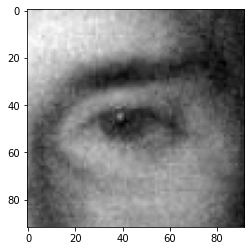

In [4]:
# Display it
plt.imshow(x, cmap='gray')
plt.show()

In [5]:
# Same for a closed eye
img = load_img('../data/eyes/samples/close/s0013_00002_0_0_0_0_0_01.png',color_mode="grayscale")
x = img_to_array(img)  # un tableau Numpy de forme (X, Y, 1)
x = x.reshape((x.shape[:2])) # un tableau Numpy de forme (X, Y)

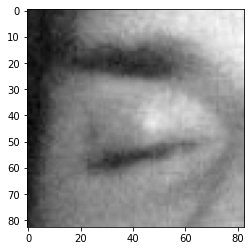

In [6]:
# Display it
plt.imshow(x/255., cmap='gray')
plt.show()

In [10]:
# Chargement des images en tableaux numpy
img_open=[] 
img_close=[]
# Dossier de base : à adapter selon votre cas
base_path = "../data/eyes/samples/"
# Pour les yeux ouverts et fermés faire :
for open_close_state in ["open/", "close/"]:
    # Recuperation liste fichiers
    for filename in os.listdir(base_path + open_close_state): 
        # On ne garde que le capteur 01
        if filename.split(".")[0][-2:]=="01":
            # Chargement de l'image en niveaux de gris et 
            # redimensionnement en 80x80 pour que toutes
            # les images aient la même taille
            img = load_img(base_path+open_close_state+filename, 
                           color_mode="grayscale", target_size=(80,80))
            # Transformation en array numpy
            x = img_to_array(img)
            # Suppression 3eme dimension inutile du chargement
            x = x.reshape((x.shape[:2]))
            # Stockage selon le dossier courant
            if open_close_state == "open/":
                img_open.append(x)
            else:
                img_close.append(x)

In [11]:
# Transformation des listes en array numpy
X_open = np.array(img_open)
X_close = np.array(img_close)

In [12]:
# Generation des target pour les yeux ouverts et fermes
y_open = np.ones(X_open.shape[0])
y_close = np.zeros(X_close.shape[0])

In [13]:
# Concatenation en X, y
X = np.concatenate((X_open, X_close))
y = np.concatenate((y_open, y_close))

# Normalisation de X
X = X / 255.

# Reshape des donnees pour l'apprentissage
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))

In [14]:
X.shape

(18903, 6400)

In [15]:
del X_open, X_close, y_open, y_close

In [16]:
# Séparation des données en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [27]:
def create_model(input_dim):
    # Nous créons un modèle dit séquentiel
    model = tf.keras.models.Sequential()
    # Ajouter le premier calque "Dense" de 100 unités,
    # et donner la dimension d'entrée (ici 80*80=6400)
    model.add(tf.keras.layers.Dense(100, input_dim=input_dim,
    activation='relu'))
    # Ajouter les autres calques "Dense" de 100 unités
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    # Ajouter enfin la couche de sortie avec une unité: le résultat prédit
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # renvoie le modèle créé
    return model

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
# Instantiate the model
model = create_model(input_dim=X_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define our callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
    TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)
]

# Finally fit the model
model.fit(
    x=X_train, y=y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, batch_size=32, callbacks=callbacks
)

Epoch 1/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7007 - loss: 0.5552 - val_accuracy: 0.8711 - val_loss: 0.3357
Epoch 2/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8632 - loss: 0.3376 - val_accuracy: 0.9030 - val_loss: 0.2621
Epoch 3/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8832 - loss: 0.2896 - val_accuracy: 0.8685 - val_loss: 0.3341
Epoch 4/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8946 - loss: 0.2663 - val_accuracy: 0.8794 - val_loss: 0.2946
Epoch 5/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9139 - loss: 0.2282 - val_accuracy: 0.9309 - val_loss: 0.1860
Epoch 6/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9146 - loss: 0.2195 - val_accuracy: 0.9344 - val_loss: 0.1831
Epoch 7/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9145 - loss: 0.2162 - val_accuracy: 0.9351 - val_loss: 0.1736
Epoch 8/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9245 - loss: 0.1885 - val_accu

In [31]:
from sklearn.metrics import *

y_pred = model.predict(X_test) > 0.5
print("Accuracy :", accuracy_score(y_test,y_pred))
print("Recall :", recall_score(y_test,y_pred))
print("Precision :", precision_score(y_test,y_pred))
print("f1_score :", f1_score(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred))

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.9705519308763887
Recall : 0.987088444157521
Precision : 0.9601255886970173
f1_score : 0.9734203406016234


,0,1
0,2446,127
1,40,3058


## Partie 2 : Regression

In [32]:
import gc
del X, y, X_train, y_train, X_test, y_test
gc.collect()

1167

In [33]:
# Chargement des données sur le centre des pupilles
df = pd.read_csv("../data/eyes/pupilCenter.csv")
df.set_index("filename", inplace=True)
df.head()

,x,y
filename,,
s0014_03817_0_0_1_0_0_01.png,36,42
s0014_03818_0_0_1_0_0_01.png,42,47
s0014_03819_0_0_1_0_0_01.png,39,44
s0014_03820_0_0_1_0_0_01.png,42,46
s0014_03821_0_0_1_0_0_01.png,45,47


In [38]:
# Chargement des images en tableaux numpy
X_open = []

# Dossier de base
base_path = "../data/eyes/samples/open/"

# Récupération liste fichiers
for filename in df.index: 
    # Premier chargement pour récupérer la forme originale de l'image
    img = load_img(base_path + filename, color_mode="grayscale")
    x = img_to_array(img)  # This is a Numpy array with shape (80, 80, 1)
    
    # Ajustement des valeurs de x, y pour le centre de la pupille
    df.loc[filename, 'x'] = int(round(df.loc[filename, 'x'] * 80 / x.shape[1]))
    df.loc[filename, 'y'] = int(round(df.loc[filename, 'y'] * 80 / x.shape[0]))
    
    # Chargement de l'image en niveaux de gris et redimensionnement en 80x80
    img = load_img(base_path + filename, color_mode="grayscale", target_size=(80, 80))
    
    # Transformation en array numpy
    x = img_to_array(img)
    
    # Suppression de la troisième dimension inutile du chargement
    x = x[:, :, 0]  # Extracting the single channel to get rid of the (80, 80, 1) shape
    
    # Stockage selon le dossier courant
    X_open.append(x)

X_open = np.array(X_open)

In [39]:
df.describe()

,x,y
count,10279.000000,10279.000000
mean,40.848818,43.154392
std,5.436118,3.782699
min,0.000000,25.000000
25%,37.000000,41.000000
50%,41.000000,43.000000
75%,44.000000,45.000000
max,73.000000,104.000000


In [40]:
# Normalisation des images
X_open = X_open/255
X_open = X_open.reshape((X_open.shape[0], np.prod(X_open.shape[1:])))
y = df.values / 80

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_open, y, test_size=.3)

In [41]:
def model(input_dim):
    # Nous créons un modèle dit séquentiel
    model = tf.keras.models.Sequential()
    # Ajouter le premier calque "Dense" de 50 unités,
    # et donner la dimension d'entrée (ici 80*80)
    model.add(tf.keras.layers.Dense(100, input_dim=input_dim,
    activation='relu'))
    # Ajouter le deuxième calque "Dense" de 80 unités
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    
    # Ajouter enfin la couche de sortie avec une unité: 
    # le résultat prédit
    model.add(tf.keras.layers.Dense(2, activation='linear'))

    # renvoie le modèle créé
    return model

In [43]:
# Define the model with regularization
mlp = model(input_dim=X_train.shape[1])
mlp.compile(optimizer='adam', loss='mean_squared_error')

# Define now our callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=30)]

# Finally fit the model
mlp.fit(x=X_train, y=y_train, 
          validation_data=(X_test, y_test), 
          epochs=50, batch_size=32, callbacks=callbacks)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0424 - val_loss: 0.0067
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [44]:
# Evaluation de la performance sur le test :
y_pred = mlp.predict(X_test)
r2_score(y_test, y_pred)

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.5996405475942626

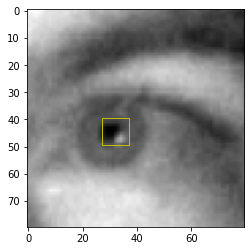

In [45]:
import matplotlib.patches as patches
index = 15
# Image to display
display = np.reshape(X_test[index], (80,80))
box = y_pred[index]
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(display, cmap='gray')
# Create a Rectangle patch
rect = patches.Rectangle((box[0]*80-5,box[1]*80-5),10,10,linewidth=1,edgecolor='y',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()